<a href="https://colab.research.google.com/github/jocelynbaduria/cmpe-297_SOTA/blob/main/Reptile_MAML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

a) Implement reptile MAML algorithm for meta learning on a small dataset from scratch (the goal is to learn data set preparation step, meta learning concepts etc,.)

(Hint : https://keras.io/examples/vision/reptile/ )

### 1. Import Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

### 2. Define the Hyperparameters

In [2]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 5

### 3. Prepare Small Dataset for training

In [7]:
class Dataset:
  ## Initialize the dataset preparation
  def __init__(self, training):
    # Download the tfrecords files containing the small dataset
    split = "train" if training else "test"
    ds = tfds.load('mnist', split=split, as_supervised=True, shuffle_files=False, try_gcs=True)
    self.data = {}

    ## Extract image and label function
    def extraction(image, label):
      image = tf.image.convert_image_dtype(image, tf.float32)
      # image = tf.image.rgb_to_grayscale(image)
      image = tf.image.resize(image, [28, 28])
      return image, label

    ## apply the extraction function to fetch the images loaded in dataset(ds)
    for image, label in ds.map(extraction):
      image = image.numpy()
      label = str(label.numpy())
      if label not in self.data:
        self.data[label] = []
      self.data[label].append(image)
    self.labels = list(self.data.keys())

  def get_mini_dataset(self, batch_size, repetitions, shots, num_classes, split=False):
    temp_labels = np.zeros(shape=(num_classes * shots))
    temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
    if split:
      test_labels = np.zeros(shape=(num_classes))
      test_images = np.zeros(shape=(num_classes, 28, 28, 1))

      # Get random subset of labels from entire label set.
    label_subset = random.choices(self.labels, k=num_classes)
    for class_idx, class_obj in enumerate(label_subset):
      ## Use enumerated index values as a temporary label for mini-batch in few shot learning.
      temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
      ## Select extra sample from each label to create a test dataset while doing a 
      ## split dataset
      if split:
          test_labels[class_idx] = class_idx
          images_to_split = random.choices(
          self.data[label_subset[class_idx]], k=shots + 1
          )
          test_images[class_idx] = images_to_split[-1]
          temp_images[
              class_idx * shots : (class_idx + 1) * shots
          ] = images_to_split[:-1]
      else:
        ## Sample needed number of images for each index in randomly selected label_subset
        temp_images[
            class_idx * shots : (class_idx + 1) * shots
        ] = random.choices(self.data[label_subset[class_idx]], k=shots)

    dataset = tf.data.Dataset.from_tensor_slices(
        (temp_images.astype(np.float32), temp_labels.astype(np.int32))
    )
    dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)
    if split: 
        return dataset, test_images, test_labels
    return dataset

import urllib3

urllib3.disable_warnings() ## Disable SSL warnings that may happen during download
train_dataset = Dataset(training=True)
test_dataset = Dataset(training=False)

### 4. Visualize some examples from the datset

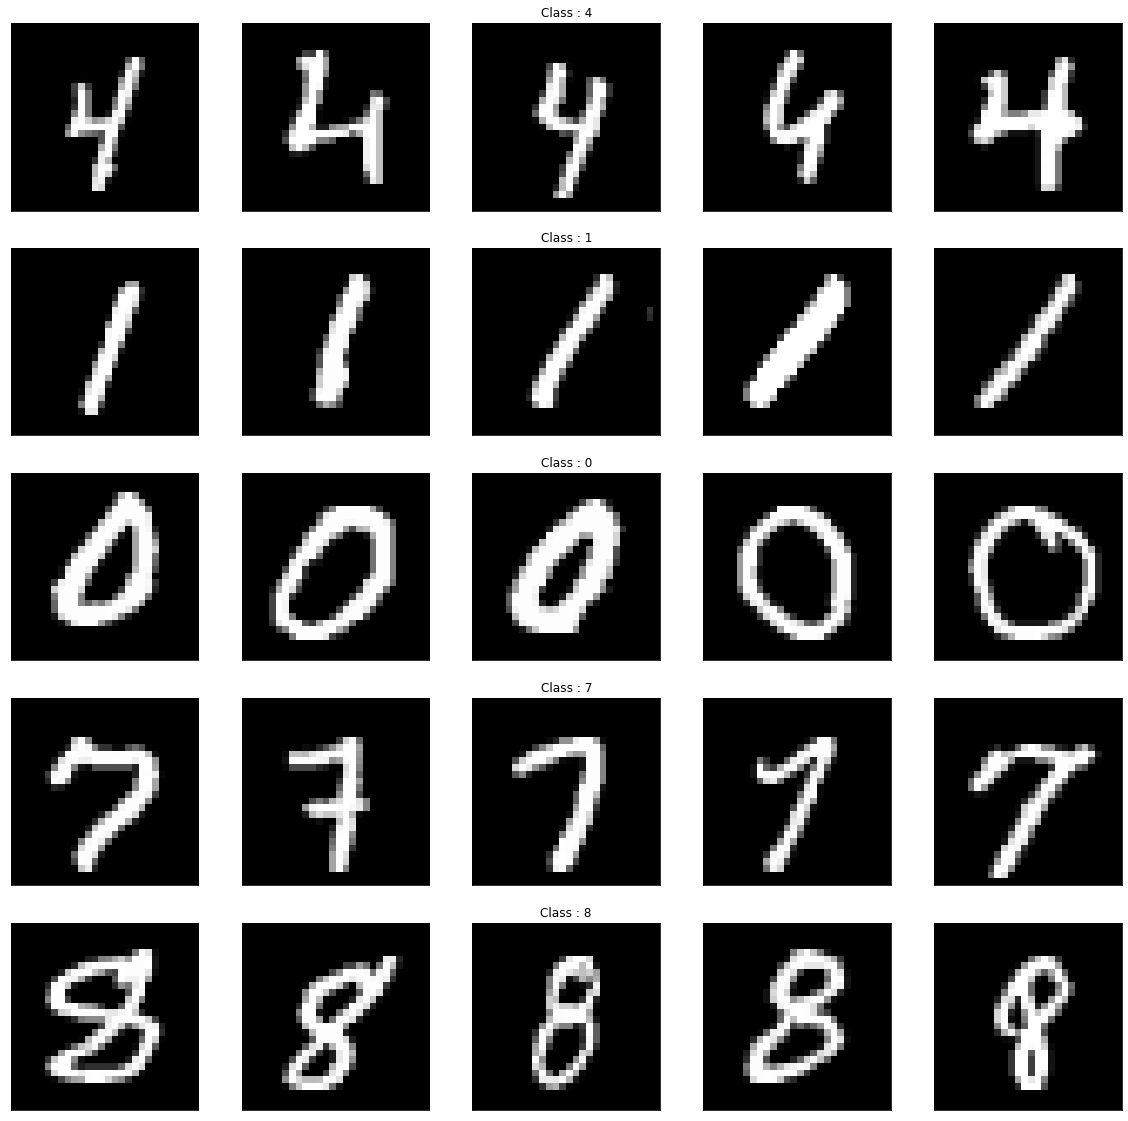

In [8]:
_, axarr = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for a in range(5):
  for b in range(5):
    temp_image = train_dataset.data[sample_keys[a]][b]
    temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    if b == 2:
      axarr[a, b].set_title("Class : " + sample_keys[a])
    axarr[a, b].imshow(temp_image, cmap="gray")
    axarr[a, b].xaxis.set_visible(False)
    axarr[a, b].yaxis.set_visible(False)
plt.show()

### 5. Build the model

In [9]:
def conv_bn(x):
  x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  return layers.ReLU()(x)

inputs = layers.Input(shape=(28, 28, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

### 6. Train the Model 

In [10]:
training = []
testing = []

for meta_iter in range(meta_iters):
  frac_done = meta_iter / meta_iters
  cur_meta_step_size = (1 - frac_done) * meta_step_size
  # Save weights temporarily from the model
  old_vars = model.get_weights()
  # Get sample from the full dataset
  mini_dataset = train_dataset.get_mini_dataset(
      inner_batch_size, inner_iters, train_shots, classes
  )
  for images, labels in mini_dataset:
    with tf.GradientTape() as tape:
      preds = model(images)
      loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
  new_vars = model.get_weights()

  # Perform SGD for the meta step
  for var in range(len(new_vars)):
    new_vars[var] = old_vars[var] + (
        (new_vars[var] - old_vars[var]) * cur_meta_step_size
    )
    # Reload the newly trained weights into the model after meta learning.
    model.set_weights(new_vars)

    # Evaluate the looping
    if meta_iter % eval_interval == 0:
      accuracies = []
      for dataset in (train_dataset, test_dataset):
        # Sample a mini dataset from the full dataset.
        train_set, test_images, test_labels = dataset.get_mini_dataset(
            eval_batch_size, eval_iters, shots, classes, split=True
        )
        old_vars = model.get_weights()
        # Train on the sample and get the resulting accuracies.
        for images, labels in train_set:
          with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
          grads = tape.gradient(loss, model.trainable_weights)
          optimizer.apply_gradients(zip(grads, model.trainable_weights))
        test_preds = model.predict(test_images)
        test_preds = tf.argmax(test_preds).numpy()
        num_correct = (test_preds == test_labels).sum()
        # Reset the weights after getting the evaluation accuracies.
        model.set_weights(old_vars)
        accuracies.append(num_correct / classes)
      training.append(accuracies[0])
      testing.append(accuracies[1])
      if meta_iter % 500 == 0:
        print("batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1]))

batch 0: train=0.400000 test=0.200000
batch 0: train=0.200000 test=0.600000
batch 0: train=0.200000 test=0.400000
batch 0: train=0.600000 test=0.400000
batch 0: train=0.600000 test=0.200000
batch 0: train=0.600000 test=1.000000
batch 0: train=1.000000 test=0.600000
batch 0: train=0.400000 test=0.600000
batch 0: train=0.400000 test=0.200000
batch 0: train=0.200000 test=0.200000
batch 0: train=0.600000 test=0.400000
batch 0: train=0.400000 test=0.400000
batch 0: train=0.400000 test=0.600000
batch 0: train=0.400000 test=0.400000
batch 0: train=0.200000 test=0.600000
batch 0: train=0.400000 test=0.400000
batch 0: train=0.600000 test=0.200000
batch 0: train=0.200000 test=0.400000
batch 0: train=0.400000 test=0.200000
batch 0: train=0.400000 test=0.600000
batch 0: train=0.400000 test=0.200000
batch 0: train=0.000000 test=0.600000
batch 0: train=0.000000 test=0.000000
batch 0: train=0.400000 test=0.200000
batch 0: train=0.200000 test=0.200000
batch 0: train=0.000000 test=0.600000
batch 500: t

### 7. Visualize Results

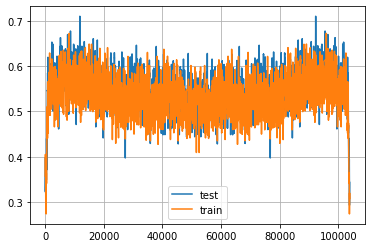

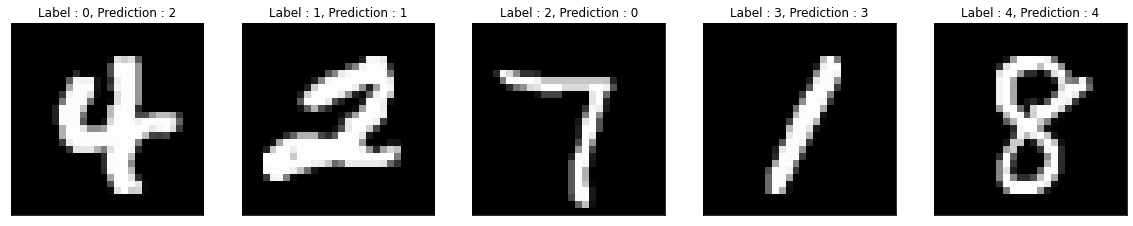

In [13]:
# Preprocess to smooth the training and testing arrays for display
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1], training, training[-1: window_length:-1]
]
test_s = np.r_[
    testing [window_length - 1 : 0 : -1], testing, testing[-1: window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
  with tf.GradientTape() as tape:
    preds = model(images)
    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
  grads = tape.gradient(loss, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())

for i, ax in zip(range(5), axarr):
  temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
  temp_image *= 255
  temp_image = np.clip(temp_image, 0, 255).astype("uint8")
  ax.set_title(
      "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
  )
  ax.imshow(temp_image, cmap="gray")
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
plt.show()